In [1]:
import sklearn
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import joblib
import pickle
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.svm import SVR, SVC
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, RandomizedSearchCV
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.base import BaseEstimator, TransformerMixin

import warnings
warnings.filterwarnings('ignore')

def evaluate_model(y_test, y_pred):
    print("Mean absolute error:\t", int(mean_absolute_error(y_test, y_pred)))
    print("Mean squared error:\t", int(mean_squared_error(y_test, y_pred)))

In [2]:
conn = sqlite3.connect('../db.sqlite3')
df_raw = pd.read_sql_query('''
SELECT "bouwjaar", "kilometer_stand", "vermogen", "prijs", "is_handgeschakeld", "is_benzine", "titel" 
FROM scraper_auto
WHERE prijs < 20000 AND prijs > 900 AND kilometer_stand < 300000
''', conn)
df = df_raw.dropna()
df.head(10)

,bouwjaar,kilometer_stand,vermogen,prijs,is_handgeschakeld,is_benzine,titel
0,2008,169504,78,2950,0.0,1,Fiat Grande Punto 1.416V Emotion 5dr Automaat ...
1,2007,219718,65,1950,1.0,1,"Fiat Grande Punto 1.2 Edizione Cool AIRCO,CRUI..."
2,2006,199908,95,1895,1.0,1,Fiat Grande Punto 1.416V Emotion AIRCO/APK
3,2006,139057,65,2950,1.0,1,"Fiat Grande Punto 1.2 Sportsound met Nap, Airco"
4,2007,222844,95,1950,1.0,1,Fiat Grande Punto 1.416V Emotion APK/NAP/CLIMA
5,2008,187215,65,2450,1.0,1,Fiat Grande Punto 1.2 Active AIRCO APK 2019 (b...
6,2010,194607,86,2895,1.0,0,Fiat Grande Punto 1.3 MJet Actual
7,2007,238443,75,1749,1.0,0,Fiat Grande Punto 1.3 JTD Active
8,2006,208650,77,1850,1.0,1,Fiat Grande Punto 1.4 Edizione Prima
9,2006,176540,78,2440,1.0,1,Fiat Grande Punto 1.4 Edizione Prima 2006 NAP!...


In [3]:
df_train, df_test = train_test_split(df, test_size=0.2)

X_train = df_train.drop(['prijs'], axis=1)
y_train = df_train[['prijs']]

X_test = df_test.drop(['prijs'], axis=1)
y_test = df_test[['prijs']]

In [4]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, x):
        x = x.str.replace('[^a-zA-Z]+', ' ', regex=True)
        x = x.str.replace(r'\b\w{1,3}\b', '', regex=True)
        x = x.str.lower()
        return x

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

text_transformer = Pipeline(steps=[
#     ('preprocessor', TextPreprocessor()),
    ('vectorizer',  CountVectorizer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, ['bouwjaar', "kilometer_stand", "vermogen"]),
        ('text',  text_transformer, 'titel')
    ],
    remainder='passthrough'
)

In [5]:
pipelines = [
    ('DecisionTreeRegressor      ', Pipeline([('preprocessor', preprocessor),('', DecisionTreeRegressor())])),
    ('Lasso                      ', Pipeline([('preprocessor', preprocessor),('', Lasso())])),
    ('SVC                      ', Pipeline([('preprocessor', preprocessor),('', SVC())])),
    ('SVR                      ', Pipeline([('preprocessor', preprocessor),('', SVR())])),
    ('KNeighborsRegressor        ', Pipeline([('preprocessor', preprocessor),('', KNeighborsRegressor())])),
    ('GradientBoostingRegressor  ', Pipeline([('preprocessor', preprocessor),('', GradientBoostingRegressor())]))
]

results = []
for name, model in pipelines:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
    results.append([name, abs(cv_results.mean()), cv_results.std()])
    
pd.DataFrame(results, columns=['name', 'MAE', 'STD']).set_index('name').astype('int').sort_values(by='MAE')

,MAE,STD
name,,
GradientBoostingRegressor,485,52
Lasso,509,44
DecisionTreeRegressor,649,85
KNeighborsRegressor,709,44
SVC,1098,82
SVR,1544,212


In [6]:
param_grid = {
    'preprocessor__numeric__imputer__strategy': ['mean', 'median'],
    'preprocessor__text__vectorizer__ngram_range': [(1,1), (1,2), (1,3)],
    'classifier__loss': ['ls', 'lad', 'huber', 'quantile'],
#     'classifier__learning_rate': np.arange(0, 0.5, 0.1)
}

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', GradientBoostingRegressor())
])

grid_search = RandomizedSearchCV(
    clf, 
    param_grid, 
    cv=10,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(("Best result: %.3f" % abs(grid_search.score(X_test, y_test))))

grid_search.best_params_

Best result: 526.303


{'preprocessor__text__vectorizer__ngram_range': (1, 3),
 'preprocessor__numeric__imputer__strategy': 'median',
 'classifier__loss': 'lad'}

In [7]:
y_pred = grid_search.best_estimator_.predict(X_test)
evaluate_model(y_test, y_pred)

Mean absolute error:	 526
Mean squared error:	 583336


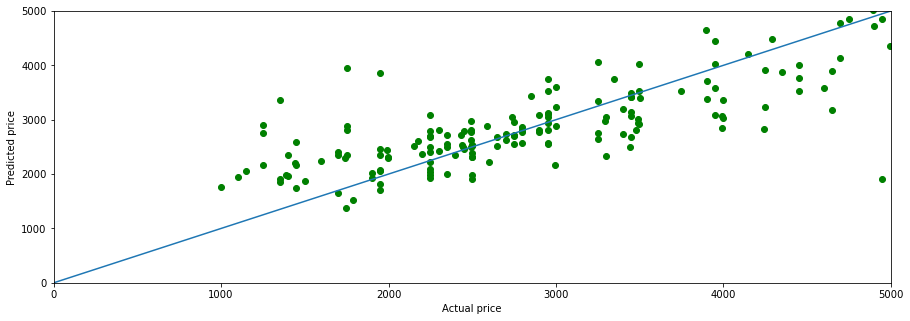

In [8]:
plt.figure(figsize=(15,5))
plt.scatter(y_test,y_pred,c='green')
plt.plot([0,5000], [0,5000])
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.xlim(0, 5000)
plt.ylim(0, 5000)
plt.show()

In [9]:
joblib.dump(grid_search.best_estimator_, 'Regressor')

['Regressor']